In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image

device = torch.device('cuda')

In [4]:
class CIFAR100CustomDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        # Load the CIFAR-100 dataset
        self.data = datasets.CIFAR100(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get an image and its label
        img, label = self.data[idx]

        # Apply the transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Resize to 64x64 for VQ-VAE input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

In [6]:
train_dataset = CIFAR100CustomDataset(root='./data', train=True, transform=transform)
test_dataset = CIFAR100CustomDataset(root='./data', train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

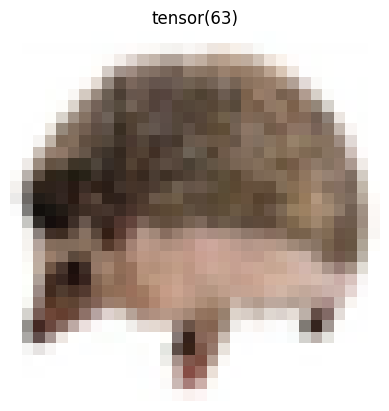

In [9]:
def show_single_image(image, label):
    plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and permute to HWC
    plt.title(label)
    plt.axis('off')
    plt.show()

show_single_image(images[10], labels[10])

In [10]:
# Encoder

class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=128, out_channels=64):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.encoder(x)

In [11]:
# Decoder

class Decoder(nn.Module):
    def __init__(self, in_channels=64, hidden_channels=128, out_channels=3):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.decoder(x)

In [12]:
# VQ

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Create embedding table
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, z_e):
        # Flatten the input feature maps
        z_e_flattened = z_e.view(-1, self.embedding_dim)
        
        # Calculate distances between z_e and embeddings
        distances = (torch.sum(z_e_flattened**2, dim=1, keepdim=True) 
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(z_e_flattened, self.embeddings.weight.t()))
        
        # Get the encoding indices (nearest embeddings)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        
        # Quantize z_e by looking up the embedding vectors
        z_q = torch.index_select(self.embeddings.weight, dim=0, index=encoding_indices.view(-1))
        z_q = z_q.view(z_e.shape)
        
        # Compute the commitment loss
        commitment_loss = self.commitment_cost * torch.mean((z_q.detach() - z_e)**2)
        
        # Add the embedding loss
        embedding_loss = torch.mean((z_q - z_e.detach())**2)
        
        # Straight-through gradient
        z_q = z_e + (z_q - z_e).detach()
        
        return z_q, commitment_loss + embedding_loss

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=1, stride=1)
        )

    def forward(self, x):
        return x + self.block(x)

In [14]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        
        # Encoder
        self.encoder = Encoder(in_channels=3, hidden_channels=128, out_channels=embedding_dim)
        
        # Vector Quantizer
        self.vq_layer = VectorQuantizer(num_embeddings=num_embeddings, 
                                        embedding_dim=embedding_dim, 
                                        commitment_cost=commitment_cost)
        
        # Decoder with Residual Blocks
        self.decoder = nn.Sequential(
            ResidualBlock(embedding_dim),
            ResidualBlock(embedding_dim),
            Decoder(in_channels=embedding_dim, hidden_channels=128, out_channels=3)
        )

    def forward(self, x):
        # Encode the input
        z_e = self.encoder(x)  # Output: [batch_size, embedding_dim, height, width]
        
        # Quantize the latent vectors
        z_q, vq_loss = self.vq_layer(z_e)
        
        # Decode the quantized vectors
        x_reconstructed = self.decoder(z_q)
        
        return x_reconstructed, vq_loss

In [15]:
model = VQVAE(num_embeddings=512, embedding_dim=64, commitment_cost=0.25).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
model.to(device)

VQVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (vq_layer): VectorQuantizer(
    (embeddings): Embedding(512, 64)
  )
  (decoder): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): Decoder(
      (decoder): Sequential(
        (0): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(

In [15]:
import torch
import torch.nn.functional as F
from tqdm import tqdm  # For progress bar

# List to store loss values for plotting
loss_values = []
val_loss_values = []

# Variable to store the best validation loss
best_val_loss = float('inf')

for epoch in range(50):  # 50 epochs
    model.train()  # Set the model to training mode
    total_loss = 0

    # TQDM progress bar for training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/50 (VQ-VAE)")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        reconstructed, vq_loss = model(images)  # Get reconstructed outputs and VQ loss

        # Calculate loss
        # 1. Reconstruction loss (MSE loss between input images and reconstructed images)
        reconstruction_loss = F.mse_loss(reconstructed, images)

        # Total loss (reconstruction + VQ)
        loss = reconstruction_loss + vq_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Update TQDM progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Calculate the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)

    # Print the average loss for the current epoch
    print(f"Epoch [{epoch+1}/50], Avg Loss: {avg_loss:.4f}")

    # --- Validation loop ---
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0

    with torch.no_grad():  # Disable gradient calculations during validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            # Forward pass
            val_reconstructed, val_vq_loss = model(val_images)

            # Calculate validation loss
            val_reconstruction_loss = F.mse_loss(val_reconstructed, val_images)
            val_loss = val_reconstruction_loss + val_vq_loss

            total_val_loss += val_loss.item()

    # Calculate the average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # Print the average validation loss for the current epoch
    print(f"Epoch [{epoch+1}/50], Avg Validation Loss: {avg_val_loss:.4f}")

    # --- Model selection based on validation loss ---
    if avg_val_loss < best_val_loss and (epoch+1) % 5 == 0:
        best_val_loss = avg_val_loss
        print(f"Validation loss improved. Saving the best model at epoch {epoch+1}.")
        torch.save(model.state_dict(), f'model_vqvae_cifar100/best_model_epoch_{epoch+1}.pth')


Epoch 1/50 (VQ-VAE): 100%|██████████| 782/782 [01:04<00:00, 12.13it/s, loss=23.4]


Epoch [1/50], Avg Loss: 48.4637
Epoch [1/50], Avg Validation Loss: 21.4068


Epoch 2/50 (VQ-VAE): 100%|██████████| 782/782 [01:11<00:00, 10.86it/s, loss=11.7]


Epoch [2/50], Avg Loss: 15.7814
Epoch [2/50], Avg Validation Loss: 13.8941


Epoch 3/50 (VQ-VAE): 100%|██████████| 782/782 [00:56<00:00, 13.89it/s, loss=7.65]


Epoch [3/50], Avg Loss: 10.2498
Epoch [3/50], Avg Validation Loss: 8.0735


Epoch 4/50 (VQ-VAE): 100%|██████████| 782/782 [01:13<00:00, 10.64it/s, loss=8.06]


Epoch [4/50], Avg Loss: 7.0883
Epoch [4/50], Avg Validation Loss: 6.4826


Epoch 5/50 (VQ-VAE): 100%|██████████| 782/782 [00:39<00:00, 19.65it/s, loss=4.41]


Epoch [5/50], Avg Loss: 5.2973
Epoch [5/50], Avg Validation Loss: 4.1538
Validation loss improved. Saving the best model at epoch 5.


Epoch 6/50 (VQ-VAE): 100%|██████████| 782/782 [00:41<00:00, 18.75it/s, loss=3.58]


Epoch [6/50], Avg Loss: 3.3917
Epoch [6/50], Avg Validation Loss: 3.0184


Epoch 7/50 (VQ-VAE): 100%|██████████| 782/782 [00:42<00:00, 18.37it/s, loss=2.63]


Epoch [7/50], Avg Loss: 2.7316
Epoch [7/50], Avg Validation Loss: 2.5894


Epoch 8/50 (VQ-VAE): 100%|██████████| 782/782 [00:39<00:00, 19.57it/s, loss=2.14]


Epoch [8/50], Avg Loss: 2.3582
Epoch [8/50], Avg Validation Loss: 2.2091


Epoch 9/50 (VQ-VAE): 100%|██████████| 782/782 [00:41<00:00, 19.04it/s, loss=1.9] 


Epoch [9/50], Avg Loss: 2.0889
Epoch [9/50], Avg Validation Loss: 2.0220


Epoch 10/50 (VQ-VAE): 100%|██████████| 782/782 [00:40<00:00, 19.19it/s, loss=1.76]


Epoch [10/50], Avg Loss: 1.8089
Epoch [10/50], Avg Validation Loss: 1.7022
Validation loss improved. Saving the best model at epoch 10.


Epoch 11/50 (VQ-VAE): 100%|██████████| 782/782 [00:40<00:00, 19.27it/s, loss=1.34]


Epoch [11/50], Avg Loss: 1.5886
Epoch [11/50], Avg Validation Loss: 1.5587


Epoch 12/50 (VQ-VAE): 100%|██████████| 782/782 [00:40<00:00, 19.28it/s, loss=1.44]


Epoch [12/50], Avg Loss: 1.4565
Epoch [12/50], Avg Validation Loss: 1.4757


Epoch 13/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.29it/s, loss=1.6] 


Epoch [13/50], Avg Loss: 1.3708
Epoch [13/50], Avg Validation Loss: 1.3640


Epoch 14/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.64it/s, loss=1.57]


Epoch [14/50], Avg Loss: 1.2955
Epoch [14/50], Avg Validation Loss: 1.3272


Epoch 15/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.82it/s, loss=1.27] 


Epoch [15/50], Avg Loss: 1.2363
Epoch [15/50], Avg Validation Loss: 1.2471
Validation loss improved. Saving the best model at epoch 15.


Epoch 16/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.00it/s, loss=1.18] 


Epoch [16/50], Avg Loss: 1.1849
Epoch [16/50], Avg Validation Loss: 1.1852


Epoch 17/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.50it/s, loss=1.09] 


Epoch [17/50], Avg Loss: 1.1511
Epoch [17/50], Avg Validation Loss: 1.1491


Epoch 18/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 15.99it/s, loss=1]    


Epoch [18/50], Avg Loss: 1.1152
Epoch [18/50], Avg Validation Loss: 1.1145


Epoch 19/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.02it/s, loss=0.975]


Epoch [19/50], Avg Loss: 1.0712
Epoch [19/50], Avg Validation Loss: 1.0761


Epoch 20/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.90it/s, loss=1.06] 


Epoch [20/50], Avg Loss: 1.0226
Epoch [20/50], Avg Validation Loss: 1.0138
Validation loss improved. Saving the best model at epoch 20.


Epoch 21/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.04it/s, loss=1.05] 


Epoch [21/50], Avg Loss: 0.9877
Epoch [21/50], Avg Validation Loss: 0.9886


Epoch 22/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.91it/s, loss=1.06] 


Epoch [22/50], Avg Loss: 0.9582
Epoch [22/50], Avg Validation Loss: 0.9606


Epoch 23/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.62it/s, loss=0.845]


Epoch [23/50], Avg Loss: 0.9290
Epoch [23/50], Avg Validation Loss: 0.9565


Epoch 24/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.83it/s, loss=1.02] 


Epoch [24/50], Avg Loss: 0.9030
Epoch [24/50], Avg Validation Loss: 0.9157


Epoch 25/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.01it/s, loss=0.83] 


Epoch [25/50], Avg Loss: 0.8798
Epoch [25/50], Avg Validation Loss: 0.8951
Validation loss improved. Saving the best model at epoch 25.


Epoch 26/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.11it/s, loss=0.71] 


Epoch [26/50], Avg Loss: 0.8599
Epoch [26/50], Avg Validation Loss: 0.8711


Epoch 27/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.63it/s, loss=0.76] 


Epoch [27/50], Avg Loss: 0.8366
Epoch [27/50], Avg Validation Loss: 0.8613


Epoch 28/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.69it/s, loss=0.851]


Epoch [28/50], Avg Loss: 0.8204
Epoch [28/50], Avg Validation Loss: 0.8499


Epoch 29/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.79it/s, loss=0.689]


Epoch [29/50], Avg Loss: 0.8046
Epoch [29/50], Avg Validation Loss: 0.8019


Epoch 30/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.35it/s, loss=0.93] 


Epoch [30/50], Avg Loss: 0.7875
Epoch [30/50], Avg Validation Loss: 0.7999
Validation loss improved. Saving the best model at epoch 30.


Epoch 31/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.69it/s, loss=0.669]


Epoch [31/50], Avg Loss: 0.7721
Epoch [31/50], Avg Validation Loss: 0.7804


Epoch 32/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.82it/s, loss=0.808]


Epoch [32/50], Avg Loss: 0.7579
Epoch [32/50], Avg Validation Loss: 0.7517


Epoch 33/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.00it/s, loss=0.763]


Epoch [33/50], Avg Loss: 0.7460
Epoch [33/50], Avg Validation Loss: 0.7540


Epoch 34/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.56it/s, loss=0.847]


Epoch [34/50], Avg Loss: 0.7322
Epoch [34/50], Avg Validation Loss: 0.7606


Epoch 35/50 (VQ-VAE): 100%|██████████| 782/782 [00:47<00:00, 16.30it/s, loss=0.828]


Epoch [35/50], Avg Loss: 0.7220
Epoch [35/50], Avg Validation Loss: 0.7314
Validation loss improved. Saving the best model at epoch 35.


Epoch 36/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.71it/s, loss=0.815]


Epoch [36/50], Avg Loss: 0.7112
Epoch [36/50], Avg Validation Loss: 0.7162


Epoch 37/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.57it/s, loss=0.662]


Epoch [37/50], Avg Loss: 0.7004
Epoch [37/50], Avg Validation Loss: 0.7119


Epoch 38/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.05it/s, loss=0.51] 


Epoch [38/50], Avg Loss: 0.6897
Epoch [38/50], Avg Validation Loss: 0.7074


Epoch 39/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.87it/s, loss=0.732]


Epoch [39/50], Avg Loss: 0.6782
Epoch [39/50], Avg Validation Loss: 0.6866


Epoch 40/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.63it/s, loss=0.598]


Epoch [40/50], Avg Loss: 0.6695
Epoch [40/50], Avg Validation Loss: 0.7040
Validation loss improved. Saving the best model at epoch 40.


Epoch 41/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.70it/s, loss=0.765]


Epoch [41/50], Avg Loss: 0.6597
Epoch [41/50], Avg Validation Loss: 0.6860


Epoch 42/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.87it/s, loss=0.523]


Epoch [42/50], Avg Loss: 0.6520
Epoch [42/50], Avg Validation Loss: 0.6616


Epoch 43/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.96it/s, loss=0.605]


Epoch [43/50], Avg Loss: 0.6439
Epoch [43/50], Avg Validation Loss: 0.6383


Epoch 44/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.76it/s, loss=0.654]


Epoch [44/50], Avg Loss: 0.6349
Epoch [44/50], Avg Validation Loss: 0.6443


Epoch 45/50 (VQ-VAE): 100%|██████████| 782/782 [00:50<00:00, 15.53it/s, loss=0.758]


Epoch [45/50], Avg Loss: 0.6279
Epoch [45/50], Avg Validation Loss: 0.6423
Validation loss improved. Saving the best model at epoch 45.


Epoch 46/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.71it/s, loss=0.56] 


Epoch [46/50], Avg Loss: 0.6206
Epoch [46/50], Avg Validation Loss: 0.6290


Epoch 47/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 16.25it/s, loss=0.588]


Epoch [47/50], Avg Loss: 0.6143
Epoch [47/50], Avg Validation Loss: 0.6267


Epoch 48/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.85it/s, loss=0.629]


Epoch [48/50], Avg Loss: 0.6081
Epoch [48/50], Avg Validation Loss: 0.6407


Epoch 49/50 (VQ-VAE): 100%|██████████| 782/782 [00:48<00:00, 15.97it/s, loss=0.568]


Epoch [49/50], Avg Loss: 0.6014
Epoch [49/50], Avg Validation Loss: 0.6169


Epoch 50/50 (VQ-VAE): 100%|██████████| 782/782 [00:49<00:00, 15.80it/s, loss=0.623]


Epoch [50/50], Avg Loss: 0.5975
Epoch [50/50], Avg Validation Loss: 0.5996
Validation loss improved. Saving the best model at epoch 50.


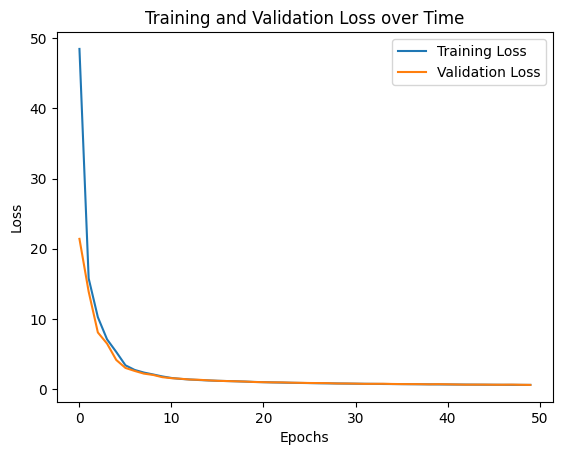

In [16]:
# Plot both training and validation losses
plt.plot(loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.show()

In [18]:
def visualize_reconstruction(model, dataset, num_samples=10, device='cuda'):
    # Load the best model weights
    model.load_state_dict(torch.load('model_vqvae_cifar100/best_model_epoch_50.pth'))
    model.eval()  # Set the model to evaluation mode
    model.to(device)

    # Create a figure for plotting the original and reconstructed images
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))

    for i in range(num_samples):
        # Get a sample from the dataset (image, label)
        img, label = dataset[i]
        
        # Add batch dimension and move image to the correct device
        img = img.unsqueeze(0).to(device)  # Shape: [1, 3, 32, 32]

        # Forward pass to get the reconstruction
        with torch.no_grad():
            reconstructed_img = model(img)[0]  # Model outputs [reconstructed_image, VQ loss]

        # Move images back to the CPU and reshape for visualization
        img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Original image (H, W, C)
        reconstructed_img = reconstructed_img.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Reconstructed image (H, W, C)

        # Plot original image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Original")
        axes[0, i].axis('off')

        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_img)
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8493455..1.076241].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70980394..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58193964..1.1193287].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8003142..0.9603262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clippi

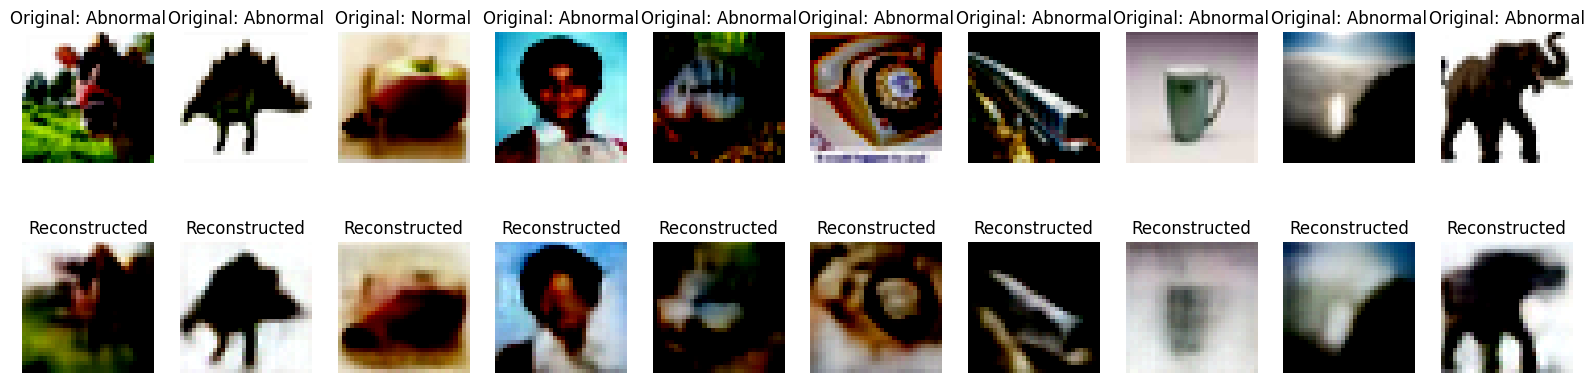

In [19]:
visualize_reconstruction(model, train_dataset, device=device)